### Imports

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline
import sounddevice as sd
from scipy.io import wavfile
import time
import math
import control
# Custom ============================
import maximumlengthsequence as mls
import impulseresponsemeasurer as irm
import plotutil
import cancellationfilter as cfilt

### Load Impulse responses from file

In [2]:
ir = np.loadtxt('ir.txt')
hstart = 14000
hlength = 300
filterLength = 1024

filt = cfilt.Cancellation_filter(ir[hstart:hstart+hlength,:], ir, filterLength)

### Record and make filters

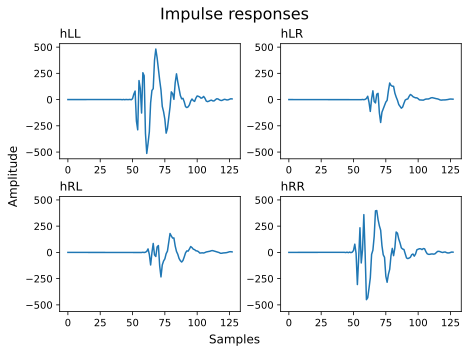

In [3]:
#ir = irm.measure_impulse_response(48000)
hstart = 14000
hlength = 128
filterLength = 1024
#filt = cfilt.Cancellation_filter(ir[hstart:hstart+hlength,:], ir, filterLength)
plotutil.plot_impulse_response(ir[hstart:hstart+hlength,:], title="Impulse responses")

np.savetxt('ir.txt',ir)

### Check impulse response Noise levels

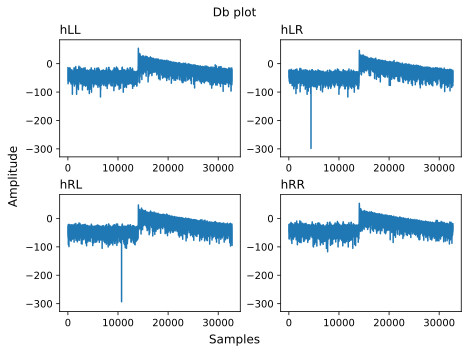

In [6]:
db = np.zeros(np.shape(ir))

for i in range(0,4):
    db[:,i] = [10 * math.log10(x**2) for x in ir[:,i]]

plotutil.plot_impulse_response(db, "Db plot")

### Compare using MLS

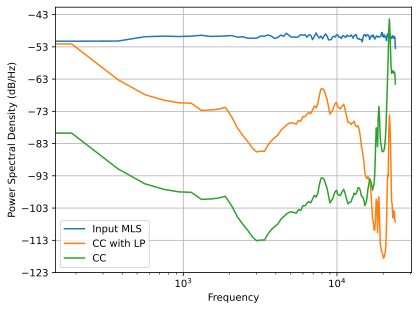

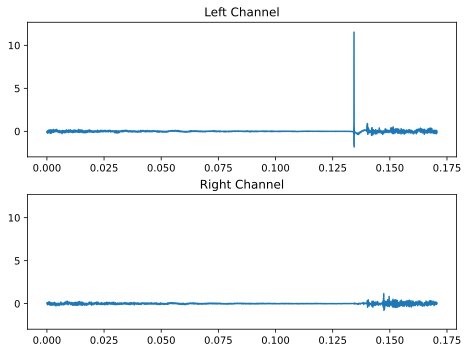

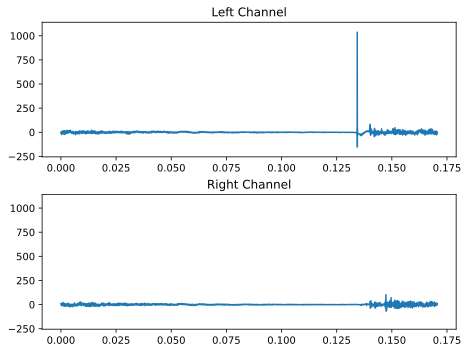

In [4]:
mls_raw, mls_sig = mls.generate_mls_signal(48000)

mls_sig_unfiltered = np.column_stack((mls_sig, np.zeros((len(mls_sig,),1))))

b = signal.firwin(16, 0.6)
mls_sig = signal.filtfilt(b, 1, mls_sig, padlen=150)    

mls_sig = np.column_stack((mls_sig, np.zeros((len(mls_sig,),1))))
mls_sig_f = filt.filter_stereo(mls_sig)
mls_sig_f_unfiltered = filt.filter_stereo(mls_sig_unfiltered)

mls_rec = sd.playrec(mls_sig_f, 48000, channels=2, dtype='float32')
sd.wait()
time.sleep(2)
mls_ref = filt.filter_reference(mls_sig)
mls_rec_d = np.column_stack((mls.decode_mls_signal(mls_rec[:,0], mls_raw)[0], mls.decode_mls_signal(mls_rec[:,1], mls_raw)[0]))
mls_sim_d = np.column_stack((mls.decode_mls_signal(mls_ref[:,0], mls_raw)[0], mls.decode_mls_signal(mls_ref[:,1], mls_raw)[0]))

plotutil.plot_psd([(mls_sig, "Unfiltered MLS"), (mls_sig_f[:,0], "Cross Cancellation with LP"), (mls_sig_f_unfiltered[:,0], "Cross Cancellation")], "Filter comparison")
plotutil.plot_stereo_comparison(mls_rec_d, mls_sim_d, "Recorded & Simulated comparison", normalize=True)

### Piano Left Ear

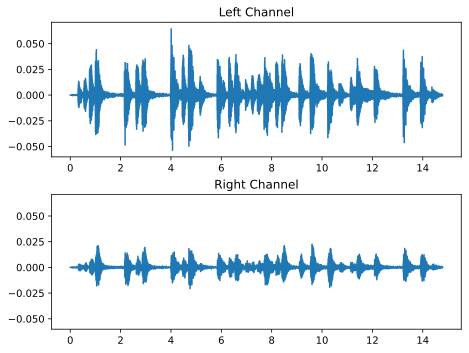

In [5]:
samplerate, data = wavfile.read('piano-loop.wav')
data[:,1] = np.zeros(len(data[:,1]))

b = signal.firwin(16, 0.8)
data[:,0] = signal.filtfilt(b, 1, data[:,0], padlen=150)  

data_f = filt.filter_stereo(data)
data_ref_f = filt.filter_reference(data)
left_recording = sd.playrec(data_f, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)
plotutil.plot_stereo(left_recording, "Piano left ear")

### Piano Right Ear

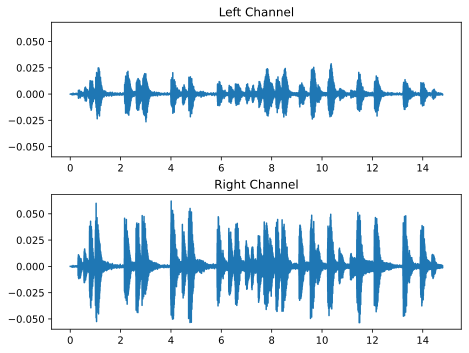

In [6]:
samplerate, data = wavfile.read('piano-loop.wav')
data[:,0] = np.zeros(len(data[:,0]))
data_f = filt.filter_stereo(data)
left_recording = sd.playrec(data_f, samplerate, channels=2, dtype='float32')
sd.wait()
time.sleep(2)

plotutil.plot_stereo(left_recording, "Piano right ear")

### Test A11

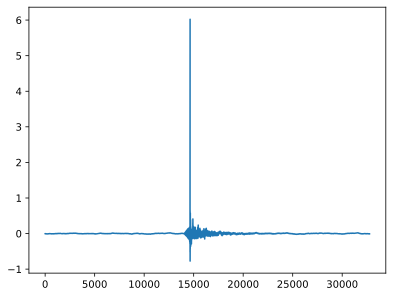

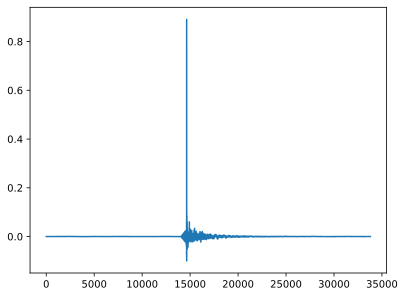

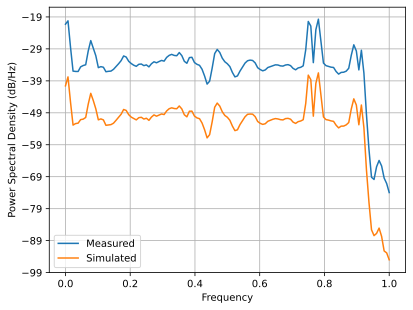

In [7]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv = signal.convolve(filt.A[0,0,:], filt.h_full[0,0,:])
mls_filt = signal.convolve(mls_sig, filt.A[0,0,:])

play = np.column_stack((mls_filt, np.zeros((len(mls_filt), 1))))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,0], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test A21

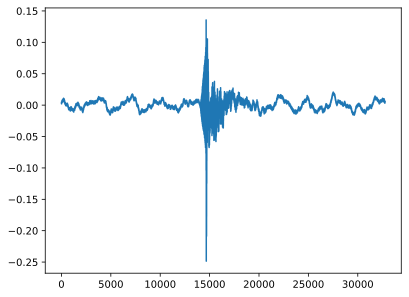

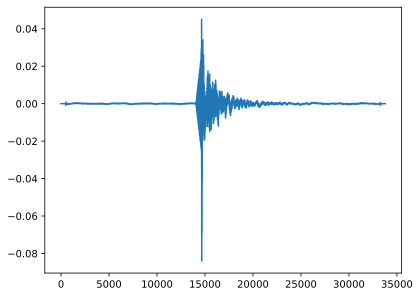

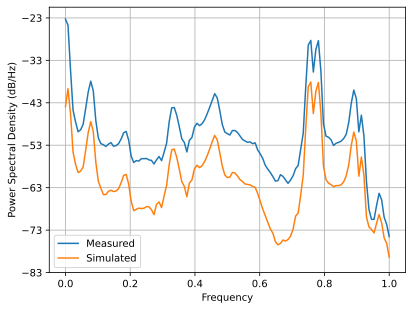

In [8]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv = signal.convolve(filt.A[1,0,:], filt.h_full[0,1,:])

mls_filt = signal.convolve(mls_sig, filt.A[1,0,:])

play = np.column_stack((np.zeros((len(mls_filt), 1)), mls_filt))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,0], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test A11 plus A21

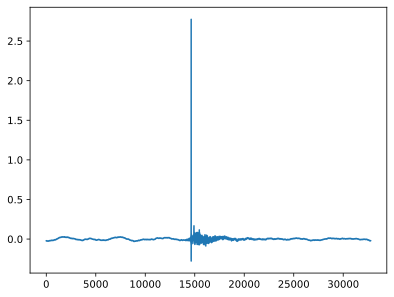

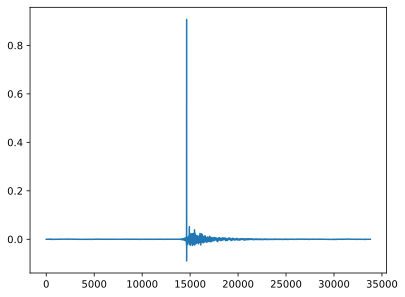

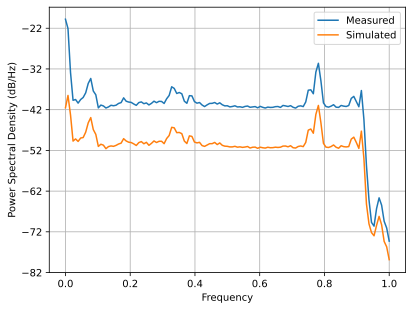

In [9]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv_A11 = signal.convolve(filt.A[0,0,:], filt.h_full[0,0,:])
filt_conv_A21 = signal.convolve(filt.A[1,0,:], filt.h_full[0,1,:])

mls_filt_A11 = signal.convolve(mls_sig, filt.A[0,0,:])
mls_filt_A21 = signal.convolve(mls_sig, filt.A[1,0,:])

filt_conv = filt_conv_A11 + filt_conv_A21

play = np.column_stack((mls_filt_A11, mls_filt_A21))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,0], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test A22

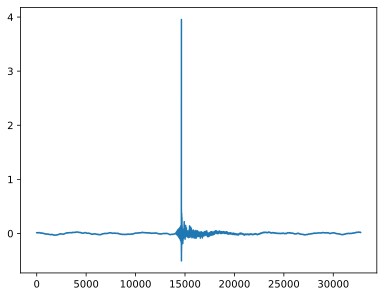

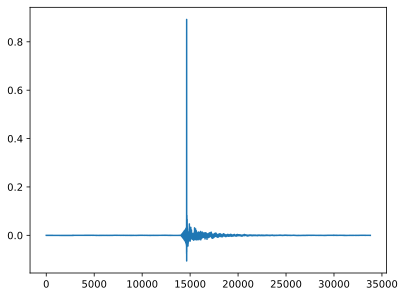

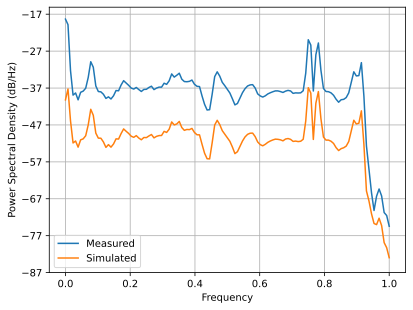

In [10]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv = signal.convolve(filt.A[1,1,:], filt.h_full[1,1,:])

mls_filt = signal.convolve(mls_sig, filt.A[1,1,:])

play = np.column_stack((np.zeros((len(mls_filt), 1)), mls_filt))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,1], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test A12

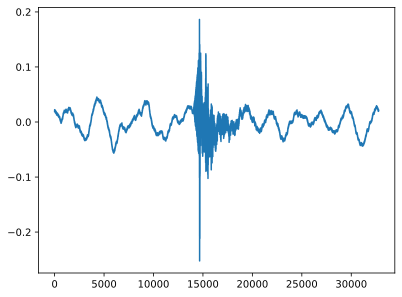

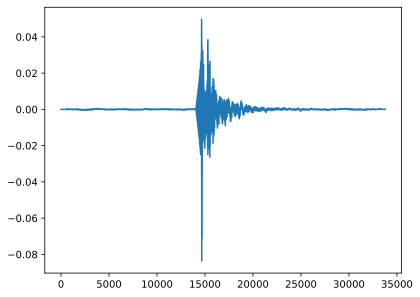

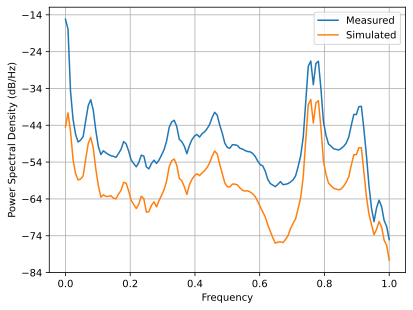

In [11]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv = signal.convolve(filt.A[0,1,:], filt.h_full[1,0,:])

mls_filt = signal.convolve(mls_sig, filt.A[0,1,:])

play = np.column_stack((mls_filt, np.zeros((len(mls_filt), 1))))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,1], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test A22 plus A12

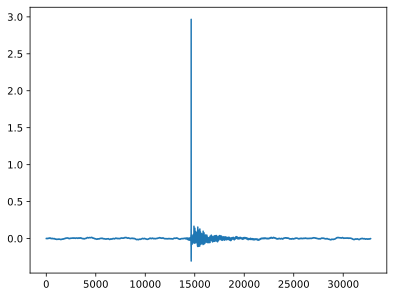

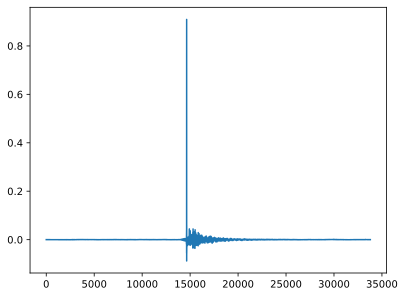

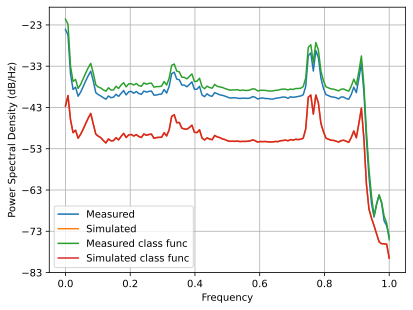

In [12]:
mls_raw, mls_sig = mls.generate_mls_signal(48000, 10, 15) 

filt_conv_A22 = signal.convolve(filt.A[1,1,:], filt.h_full[1,1,:])
filt_conv_A12 = signal.convolve(filt.A[0,1,:], filt.h_full[1,0,:])

mls_filt_A22 = signal.convolve(mls_sig, filt.A[1,1,:])
mls_filt_A12 = signal.convolve(mls_sig, filt.A[0,1,:])

filt_conv = filt_conv_A22 + filt_conv_A12

play = np.column_stack((mls_filt_A12, mls_filt_A22))

play /= np.max(np.abs(play))
play *= 0.8

mls_rec = sd.playrec(play, 48000, channels=2)

sd.wait()
time.sleep(1)

mls_decoded, q = mls.decode_mls_signal(mls_rec[:,1], mls_raw)

plotutil.plot_comparison(mls_decoded, filt_conv, "A11 Simulated & Recorded", normalize=True)
plotutil.plot_psd([(mls_decoded, "Measured"), (filv_conv, "Simulated")])

### Test Left Filters

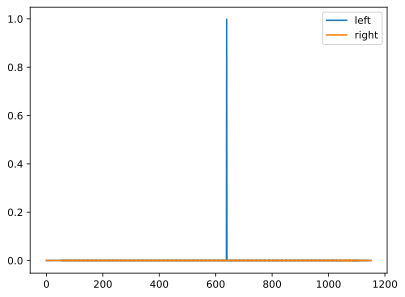

: 

In [15]:
l = signal.convolve(filt.h_full[0,0,:], filt.A[0,0,:]) + signal.convolve(filt.h_full[0,1,:], filt.A[1,0,:])
r = signal.convolve(filt.h_full[1,1,:], filt.A[1,0,:]) + signal.convolve(filt.h_full[1,0,:], filt.A[0,0,:])

l = signal.convolve(filt.h[0,0,:], filt.A[0,0,:]) + signal.convolve(filt.h[0,1,:], filt.A[1,0,:])
r = signal.convolve(filt.h[1,1,:], filt.A[1,0,:]) + signal.convolve(filt.h[1,0,:], filt.A[0,0,:])

plt.plot(l, label='left')
plt.plot(r, label='right')
plt.legend()

### Test Right Filters

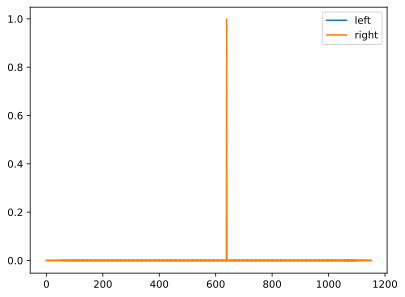

In [14]:
l = signal.convolve(filt.h_full[0,1,:], filt.A[1,1,:]) + signal.convolve(filt.h_full[0,0,:], filt.A[0,1,:])
r = signal.convolve(filt.h_full[1,1,:], filt.A[1,1,:]) + signal.convolve(filt.h_full[1,0,:], filt.A[0,1,:])

l = signal.convolve(filt.h[0,1,:], filt.A[1,1,:]) + signal.convolve(filt.h[0,0,:], filt.A[0,1,:])
r = signal.convolve(filt.h[1,1,:], filt.A[1,1,:]) + signal.convolve(filt.h[1,0,:], filt.A[0,1,:])

plt.plot(l, label='left')
plt.plot(r, label='right')
plt.legend()

### Test consistency of filters

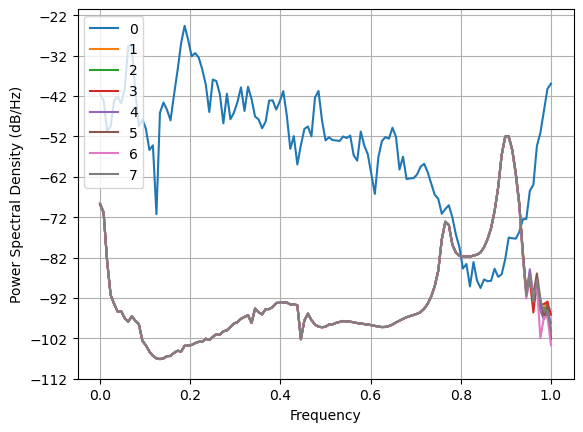

In [4]:
filters = []

filterCount = 8

for i in range(0,filterCount):
    ir = irm.measure_impulse_response(48000)
    hstart = 14000
    hlength = 512
    filterLength = 1024
    f = cfilt.Cancellation_filter(ir[hstart:hstart+hlength,:], ir, filterLength)
    filters.append(f)
    time.sleep(1)

for i in range(0, filterCount):
    plt.psd(filters[i].A[0,0,:], label=str(i))
plt.legend()
plt.show()